# NAIVE BAYES ON AMAZON FINE FOOD REVIEWS DATASET

Data Source **[https://www.kaggle.com/snap/amazon-fine-food-reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews)**

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.It consist of data collected from past many years. This dataset consist of approx 550k reviews. 

![Naive Bayes Model on Amazon Review Dataset ](https://blog.easysol.net/wp-content/uploads/2018/03/Feature-Image.jpg) 

## SNIPPET
1. Converted the reviews using NLP techniques i.e BOW, tf-IDF, Word2Vec and tf-IDF Word2Vec.
2. Applied Naive Bayes on the dataset with both techniques i.e Bernaulli Naive Bayes and Multinomial Naive Bayes. 
3. Calculated Train Error, CV Error and Test Error to determine the performance and to ensure best fit.
4. Compared performance of each model using accuracy, f1-score, recall, precision.
5. Made confusion matrix between predicted and tested data.
6. Conclusion based on the obtained results.

## DATA INFORMATION
* Number of reviews: 568,454
* Number of users: 256,059
* Number of products: 74,258
* Timespan: Oct 1999 - Oct 2012
* Number of Attributes/Columns in data: 10 

## ATTRIBUTE INFORMATION

1.  Id
2.  ProductId - unique identifier for the product
3.  UserId - unqiue identifier for the user
4.  ProfileName
5.  HelpfulnessNumerator - number of users who found the review helpful
6.  HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7.  Score - rating between 1 and 5
8.  Time - timestamp for the review
9.  Summary - brief summary of the review
10. Text - text of the review

## OBJECTIVE
Predict the polarity of the review using Naive Bayes and Compare both models i.e Bernaulli and Multinomial to find the best one and ensure that the model is neither overfitting nor underfitting.   

## LOADING

In [1]:
import sqlite3
import pandas as pd

In [2]:
conn=sqlite3.connect('./final.sqlite') # making a connection with sqlite
Data=pd.read_sql_query("""SELECT * FROM Reviews""",conn)

In [3]:
Data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


## MAPPING

In [4]:
# function to map the polarity as 0 or 1
def sign(x):
    if x=='positive':
        return 1
    else:
        return 0

Data['Score']=Data['Score'].map(sign)

In [5]:
# Dimension
print(Data.shape)

(364171, 12)


In [6]:
Data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

## SORTING

In [7]:
# Sorting the data according to Time.
Data.sort_values('Time',inplace=True)

## IMPORTING

In [93]:
import re
import gensim
import pickle
import numpy as np
import time
import seaborn as sns
from scipy import sparse
from prettytable import PrettyTable
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import statistics as s
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

## FUNCTIONS 

### 1. Split Function

In [9]:
'''
This function is used to split that data into train and test.
It uses the function to split it into 70-30 %.
It does not shuffle so the data is distributed sequentially.
'''
def Split(d1,d2):
    a,b,c,d= train_test_split(d1,d2,test_size=0.3,shuffle=False) # Splitting it in 70-30 without shuffling.
    return a,b,c,d

### 2. Naive Bayes With Grid Search CV

In [10]:
'''
This function takes training data and algorithm as input and gives execution time, accuracy and the optimal value of alpha
on that data.
It uses GridSearch CV.
'''
def NB(X,Y,s):
    start = time.time()
    tscv = TimeSeriesSplit(n_splits=10)
    parameters = {'alpha':[0.00001,0.0001,0.001,0.01,0.02,0.08,0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,1,5,10,20,50,100,500,1000,10000]}
    if s=='B':
        clf = BernoulliNB()
    else:
        clf = MultinomialNB()
    g = GridSearchCV(clf,parameters,cv=tscv,return_train_score=True,n_jobs=-1)
    g.fit(X,Y)
    end = time.time()
    t=end-start
    return t,g

### 3. Hyperparameter vs Accuracy Plot

In [11]:
'''
This function takes Object of gridsearch cv and plots the graph for accuracy vs alpha's.
'''
def Accplot(h,nlp,algo):
    acu = h.cv_results_['mean_test_score']
    alp = [0.00001,0.0001,0.001,0.01,0.02,0.08,0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,1,5,10,20,50,100,500,1000,10000]
    sns.set_style("darkgrid")
    plt.plot(alp,acu,'b--')
    plt.xlabel("Alpha's",fontsize=15, color='black')
    plt.ylabel("Accuracy",fontsize=15, color='black')
    plt.title("Accuracy -" + nlp + algo,fontsize=15, color='black')
    plt.show()

### 4. Hyperparameter vs Error Plot

In [12]:
'''
This function takes the grid cv object and calculates CV accuracy and Training accuracy.
Output is train error and CV error.
It also plots the graph between Hyperparameters vs Errors.
'''

def Errorplot(h):
    alp = [0.00001,0.0001,0.001,0.01,0.02,0.08,0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,1,5,10,20,50,100,500,1000,10000]
    cv_acc = list(h.cv_results_['mean_test_score'])
    train_acc = list(h.cv_results_['mean_train_score'])
    a = [1 - x for x in cv_acc]
    b = [1 - x for x in train_acc]
    plt.plot(alp, a, '-b', label='CV Error')
    plt.plot(alp, b, '-r', label='Train Error')
    plt.legend(loc='lower right')
    plt.xlabel("Hyperparameters",fontsize=15, color='black')
    plt.ylabel("Train Error & Cv Error",fontsize=15, color='black')
    plt.title("Train vs CV Error on Hyperparameters" ,fontsize=15, color='black')
    plt.show()
    print("The Train Error is -: ",round(s.mean(b),3)*100,"%\n")
    print("The CV Error is -: ",round(s.mean(a),3)*100,"%\n") 

### 5. Predicting On Best Hyperparameter

In [13]:
'''
It runs the desired algorithm on the optimal value of Alpha we get from training part.
It also returns predicted values.
'''
def predict(s,a,xtrain,ytrain,xtest):
    if s=='B':
        clf = BernoulliNB(alpha = a)        
    else:
        clf = MultinomialNB(alpha = a)
    clf.fit(xtrain,ytrain)
    pred=clf.predict(xtest)
    return clf,pred

### 6. Performance Measurement

In [14]:
'''
It gives the performance in terms of accuracy, F1 Score, recall, precision and test error also.
'''
def Measure(test,pre):
    print("Accuracy on Test Data -: ",round(((accuracy_score(test,pre))*100),3),"% \n")
    print("F1 Score -:  ",round(((f1_score(test,pre))),3),"\n")
    print("Precision Score -: ",round(((precision_score(test,pre))),3),"\n")
    print("Recall Score -: ",round((recall_score(test,pre)),3),"\n")
    print("Test Error -: ",100-round(((accuracy_score(test,pre))*100),3))

### 7. Confusion Matrix

In [15]:
'''
It gives confusion matrix between actual and predicted values.
'''
def CF(test,pre):
    cf = confusion_matrix(test,pre)
    df =pd.DataFrame(cf,index=[0,1],columns=[0,1])
    sns.set(font_scale=1.5)
    sns.heatmap(df,annot=True,annot_kws={"size" :20},fmt='g')
    return plt.show()

### 8. Informative Features

In [16]:
'''
This functions draws a pretty table of important features among positive and negative classes each according
to the probabilities.
'''
def IF(c,co):
    a = c.feature_log_prob_
    f = co.get_feature_names()
    l1 = list(zip(a[0],f))
    l1 = sorted(l1,reverse=True)
    l2 = list(zip(a[1],f))
    l2 = sorted(l2,reverse=True)
    x = PrettyTable()
    x.field_names = ["Top Negative Features", "Probability_neg", "Top Positive Features", "Probability_pos"]
    n=1
    for i in range(25):
        x.add_row([l1[i][1],l1[i][0],l2[i][1],l2[i][0]])
        n+=2
    print(x)

### 9. Using Pickle - File Handling

In [17]:
'''
These functions are used to save and retrieve the information and use it afterwards for future reference.
'''

# Method to Save the data.
def save(o,f):
    op=open(f+".p","wb")
    pickle.dump(o,op)

# Method to retrieve the data.    
def retrieve(f):
    op=open(f+".p","rb")
    ret=pickle.load(op)
    return ret

### 10. List Of Words

In [18]:
'''
This function takes sentences as input and it splits the sentence into words and makes list of words
for each and every review.
'''

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

def LOW(l):
    i=0
    list_of_sent=[] # list to store all the lists.
    for sent in l:
        filtered_sentence=[] # list to store each review.
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):    
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue 
        list_of_sent.append(filtered_sentence)
    return list_of_sent

# NAIVE BAYES MODEL ON BAG OF WORDS ( BOW )

![](https://cdn-images-1.medium.com/max/1600/0*JpqZhCNsQ_OGaRkB.jpg)

###  SPLITTING INTO TRAIN AND TEST

In [19]:
x_train, x_test, y_train, y_test = Split(Data['CleanedText'].values,Data['Score'].values)

In [20]:
print("-----------------------TRAIN DATA------------------------------------")
print(x_train.shape)
print(y_train.shape)
print("---------------------------------------------------------------------")
print("\n-----------------------TEST DATA-------------------------------------")
print(x_test.shape)
print(y_test.shape)

-----------------------TRAIN DATA------------------------------------
(254919,)
(254919,)
---------------------------------------------------------------------

-----------------------TEST DATA-------------------------------------
(109252,)
(109252,)


###  CONVERTING REVIEWS INTO VECTORS USING BOW

In [21]:
count = CountVectorizer(ngram_range=(1,2)) 
x_train = count.fit_transform(x_train)
x_test = count.transform(x_test)

In [22]:
print("Train Dataset Shape -: ",x_train.shape)
print("Test Dataset Shape -: ",x_test.shape)

Train Dataset Shape -:  (254919, 2290079)
Test Dataset Shape -:  (109252, 2290079)


###   NORMALIZING THE DATA 

In [23]:
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

## BERNAULLI NAIVE BAYES

![Bernaulli NB](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRlw46MRGl3Ox4cZTzXJ0PksGvVc4xWxjRsPQy949u8llCO399y)

### Calling NB Function with training dataset

In [24]:
t, g = NB(x_train, y_train, 'B')

In [24]:
print("Time taken to complete -: ",t,"sec\n")
print("Best Hyperparameter -: ",g.best_params_,"\n")
print("Accuracy -: ",round(g.best_score_*100,3),"%")

Time taken to complete -:  229.48659324645996 sec

Best Hyperparameter -:  {'alpha': 0.001} 

Accuracy -:  89.718 %


### Alpha vs Accuracy Plot

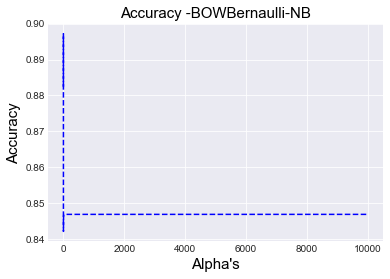

In [25]:
Accplot(g, 'BOW', 'Bernaulli-NB')

### Hyperparameters vs Error Plot

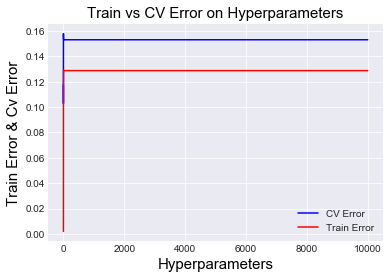

The Train Error is -:  7.3 %

The CV Error is -:  14.3 %



In [26]:
Errorplot(g)

### Predicting on Best Hyperparameter

In [27]:
clf, pred = predict('B', 0.001, x_train, y_train, x_test)

### Measuring Performance

In [28]:
Measure(y_test,pred)

Accuracy on Test Data -:  88.871 % 

F1 Score -:   0.936 

Precision Score -:  0.889 

Recall Score -:  0.988 

Test Error -:  11.129


### Confusion Matrix

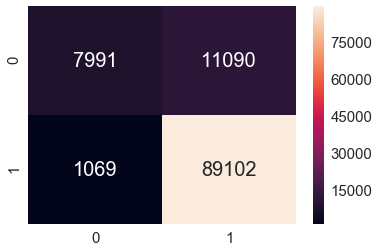

In [29]:
CF(y_test,pred)

### Top Informative Features With Probabilities

In [30]:
IF(clf,count)

+-----------------------+-----------------+-----------------------+-----------------+
| Top Negative Features | Probability_neg | Top Positive Features | Probability_pos |
+-----------------------+-----------------+-----------------------+-----------------+
|          not          | -0.591495978586 |          not          |   -1.143502781  |
|          tast         | -0.978229341871 |          like         |  -1.18976586811 |
|          like         |  -1.00029217837 |          tast         |  -1.20777610866 |
|        product        |  -1.20966002121 |          love         |  -1.27277138223 |
|          one          |  -1.35423340058 |          good         |  -1.27701143801 |
|         would         |  -1.42066838439 |         great         |  -1.29398558433 |
|          veri         |  -1.46121372351 |         flavor        |  -1.42895460263 |
|          tri          |  -1.46621430161 |          one          |  -1.47244014142 |
|         flavor        |  -1.53763527983 |          v

## MULTINOMIAL NAIVE BAYES

### Calling NB Function with training dataset

In [31]:
t, g = NB(x_train, y_train, 'M')

In [32]:
print("Time taken to complete -: ",t,"sec\n")
print("Best Hyperparameter -: ",g.best_params_,"\n")
print("Accuracy -: ",round(g.best_score_*100,3),"%")

Time taken to complete -:  195.02917623519897 sec

Best Hyperparameter -:  {'alpha': 0.001} 

Accuracy -:  90.289 %


### Alpha vs Accuracy Plot

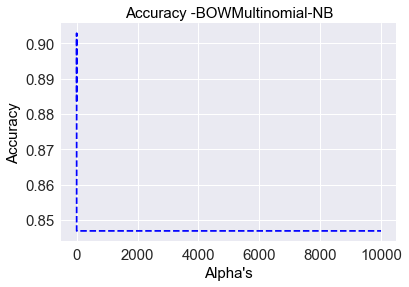

In [33]:
Accplot(g, 'BOW', 'Multinomial-NB')

### Hyperparameters vs Error Plot

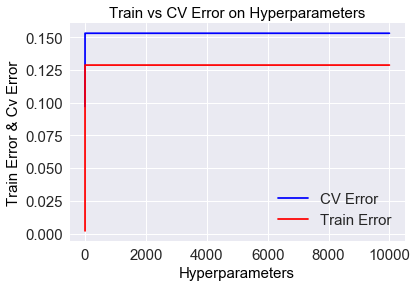

The Train Error is -:  9.9 %

The CV Error is -:  14.1 %



In [34]:
Errorplot(g)

### Predicting on Best Hyperparameter

In [35]:
clf, pred = predict('M', 0.001, x_train, y_train, x_test)

### Measuring Performance

In [36]:
Measure(y_test,pred)

Accuracy on Test Data -:  88.916 % 

F1 Score -:   0.937 

Precision Score -:  0.886 

Recall Score -:  0.993 

Test Error -:  11.084


### Confusion Matrix

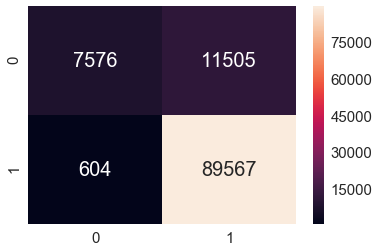

In [38]:
CF(y_test,pred)

### Top Informative Features With Probabilities

In [37]:
IF(clf,count)

+-----------------------+-----------------+-----------------------+-----------------+
| Top Negative Features | Probability_neg | Top Positive Features | Probability_pos |
+-----------------------+-----------------+-----------------------+-----------------+
|          not          |  -4.39456968128 |          not          |  -5.08733210663 |
|          tast         |  -4.80287504633 |          like         |  -5.11363424438 |
|          like         |  -4.93626209316 |          tast         |  -5.11587401159 |
|        product        |  -5.10272224388 |          love         |  -5.13784997904 |
|         flavor        |  -5.42163426918 |         great         |  -5.15135938134 |
|          one          |  -5.4258532145  |          good         |  -5.18779629708 |
|          veri         |  -5.50994836331 |         flavor        |  -5.30372976915 |
|         would         |  -5.54822196322 |          use          |  -5.41323068891 |
|          tri          |  -5.56735853717 |          v

# tf-IDF

![](https://lphinternetservices.com/images/TF-IDF-define.jpg)

###  SPLITTING INTO TRAIN AND TEST

In [39]:
x_train, x_test, y_train, y_test = Split(Data['CleanedText'].values,Data['Score'].values)

In [40]:
print("-----------------------TRAIN DATA------------------------------------")
print(x_train.shape)
print(y_train.shape)
print("---------------------------------------------------------------------")
print("\n-----------------------TEST DATA-------------------------------------")
print(x_test.shape)
print(y_test.shape)

-----------------------TRAIN DATA------------------------------------
(254919,)
(254919,)
---------------------------------------------------------------------

-----------------------TEST DATA-------------------------------------
(109252,)
(109252,)


###  CONVERTING REVIEWS INTO VECTORS USING tf-IDF

In [41]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) 
x_train = tf_idf_vect.fit_transform(x_train)
x_test = tf_idf_vect.transform(x_test)

In [42]:
print("Train Dataset Shape -: ",x_train.shape)
print("Test Dataset Shape -: ",x_test.shape)

Train Dataset Shape -:  (254919, 2290079)
Test Dataset Shape -:  (109252, 2290079)


###   NORMALIZING THE DATA 

In [43]:
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

### BERNAULLI NAIVE BAYES

![Bernaulli NB](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRlw46MRGl3Ox4cZTzXJ0PksGvVc4xWxjRsPQy949u8llCO399y)

### Calling NB Function with training dataset

In [44]:
t, g = NB(x_train, y_train, 'B')

In [45]:
print("Time taken to complete -: ",t,"sec\n")
print("Best Hyperparameter -: ",g.best_params_,"\n")
print("Accuracy -: ",round(g.best_score_*100,3),"%")

Time taken to complete -:  264.5981376171112 sec

Best Hyperparameter -:  {'alpha': 0.001} 

Accuracy -:  89.718 %


### Alpha vs Accuracy Plot

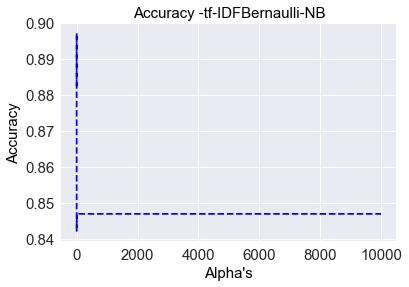

In [46]:
Accplot(g, 'tf-IDF', 'Bernaulli-NB')

### Hyperparameters vs Error Plot

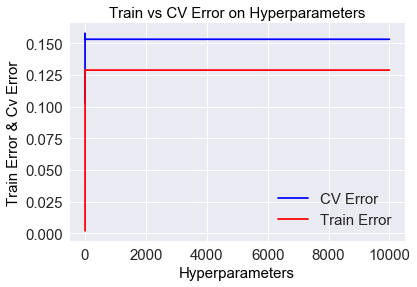

The Train Error is -:  7.3 %

The CV Error is -:  14.3 %



In [47]:
Errorplot(g)

### Predicting on Best Hyperparameter

In [48]:
clf, pred = predict('B', 0.001, x_train, y_train, x_test)

### Measuring Performance

In [49]:
Measure(y_test,pred)

Accuracy on Test Data -:  88.871 % 

F1 Score -:   0.936 

Precision Score -:  0.889 

Recall Score -:  0.988 

Test Error -:  11.129


### Confusion Matrix

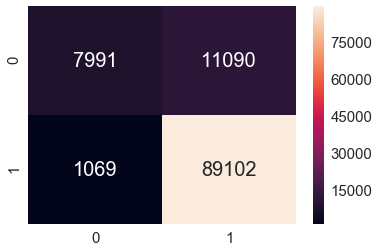

In [50]:
CF(y_test,pred)

### Top Informative Features With Probabilities

In [51]:
IF(clf,tf_idf_vect)

+-----------------------+-----------------+-----------------------+-----------------+
| Top Negative Features | Probability_neg | Top Positive Features | Probability_pos |
+-----------------------+-----------------+-----------------------+-----------------+
|          not          | -0.591495978586 |          not          |   -1.143502781  |
|          tast         | -0.978229341871 |          like         |  -1.18976586811 |
|          like         |  -1.00029217837 |          tast         |  -1.20777610866 |
|        product        |  -1.20966002121 |          love         |  -1.27277138223 |
|          one          |  -1.35423340058 |          good         |  -1.27701143801 |
|         would         |  -1.42066838439 |         great         |  -1.29398558433 |
|          veri         |  -1.46121372351 |         flavor        |  -1.42895460263 |
|          tri          |  -1.46621430161 |          one          |  -1.47244014142 |
|         flavor        |  -1.53763527983 |          v

### MULTINOMIAL  NAIVE BAYES

### Calling NB Function with training dataset

In [52]:
t, g = NB(x_train, y_train, 'M')

In [53]:
print("Time taken to complete -: ",t,"sec\n")
print("Best Hyperparameter -: ",g.best_params_,"\n")
print("Accuracy -: ",round(g.best_score_*100,3),"%")

Time taken to complete -:  213.79974484443665 sec

Best Hyperparameter -:  {'alpha': 0.02} 

Accuracy -:  89.227 %


### Alpha vs Accuracy Plot

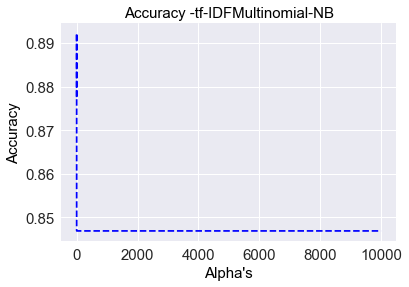

In [54]:
Accplot(g, 'tf-IDF', 'Multinomial-NB')

### Hyperparameters vs Error Plot

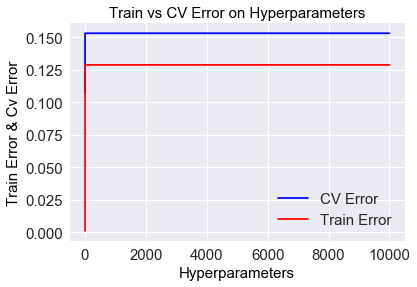

The Train Error is -:  9.1 %

The CV Error is -:  14.1 %



In [55]:
Errorplot(g)

### Predicting on Best Hyperparameter

In [56]:
clf, pred = predict('M', 0.02, x_train, y_train, x_test)

### Measuring Performance

In [57]:
Measure(y_test,pred)

Accuracy on Test Data -:  89.811 % 

F1 Score -:   0.941 

Precision Score -:  0.897 

Recall Score -:  0.99 

Test Error -:  10.189


### Confusion Matrix

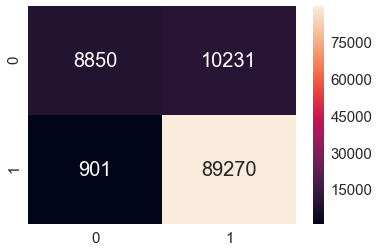

In [58]:
CF(y_test,pred)

### Top Informative Features With Probabilities

In [59]:
IF(clf,tf_idf_vect)

+-----------------------+-----------------+-----------------------+-----------------+
| Top Negative Features | Probability_neg | Top Positive Features | Probability_pos |
+-----------------------+-----------------+-----------------------+-----------------+
|          not          |  -5.80290394131 |         great         |  -6.2561340553  |
|          tast         |  -6.13678432729 |          love         |  -6.26498470791 |
|          like         |  -6.2789461342  |          tast         |  -6.31363447518 |
|        product        |  -6.32403385514 |          tea          |  -6.31801850573 |
|         would         |  -6.62441282194 |          like         |  -6.32230202326 |
|         flavor        |  -6.63971618579 |          good         |  -6.32603250711 |
|         coffe         |  -6.64264841499 |          not          |  -6.36144060994 |
|          one          |  -6.6625209448  |         flavor        |  -6.38468385105 |
|          veri         |  -6.72495979549 |         co

# Avg Word2Vec

![](https://adriancolyer.files.wordpress.com/2016/04/word2vec-gender-relation.png?w=596)

### SPLIT DATA INTO TRAIN AND TEST

In [25]:
'''
Here we are taking two lists and putting the data separate as Train in l4 and Test in l5.
'''

l4=[]
for i in range(254919):
    l1=Data['CleanedText'].values[i]
    l2=str(l1)
    l4.append(l2)

l5=[]
for i in range(254919,364171,1):
    l1=Data['CleanedText'].values[i]
    l2=str(l1)
    l5.append(l2)

### MAKING LIST OF WORDS

In [26]:
Train = LOW(l4)
Test = LOW(l5)

In [27]:
print("Length of Train Dataset -: ",len(Train))
print("Length of Test Dataset -: ",len(Test))

Length of Train Dataset -:  254919
Length of Test Dataset -:  109252


In [28]:
print("____________________________________ TRAINING DATA ___________________________________________________")
print(Data['CleanedText'].values[3])

print("\n" + "********************Converted these sentences into a list of words each***********************\n ")

# First Review with breaking into words. 
print(Train[3])

#-------------------------------------------------------------------------------------------------------------------
print("--------------------------------------------------------------------------------------------------------------")

print("____________________________________ TEST DATA ___________________________________________________")

print(Data['CleanedText'].values[-1])

print("\n" + "********************Converted these sentences into a list of words each***********************\n ")

# First Review with breaking into words. 
print(Test[-1])

____________________________________ TRAINING DATA ___________________________________________________
b'twist rumplestiskin captur film star michael keaton geena davi prime tim burton masterpiec rumbl absurd wonder pace point not dull moment'

********************Converted these sentences into a list of words each***********************
 
['btwist', 'rumplestiskin', 'captur', 'film', 'star', 'michael', 'keaton', 'geena', 'davi', 'prime', 'tim', 'burton', 'masterpiec', 'rumbl', 'absurd', 'wonder', 'pace', 'point', 'not', 'dull', 'moment']
--------------------------------------------------------------------------------------------------------------
____________________________________ TEST DATA ___________________________________________________
b'mix make good bread also use make pop over near made wheat wife celiac use bread popov pizza crust'

********************Converted these sentences into a list of words each***********************
 
['bmix', 'make', 'good', 'bread', 'also', 'us

### TRAINING THE MODEL ON TRAIN DATA

In [29]:
w2v_model=gensim.models.Word2Vec(Train,min_count=2,size=100, workers=4)

###  CONVERTING REVIEWS INTO VECTORS USING AVG WORD2VEC

In [30]:
'''
Converting the reviews into vectors by using the above trained model.
'''
#-------------------------------------- TRAIN DATASET ------------------------------------------------------------------
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in Train: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

#------------------------------------- TEST DATASET --------------------------------------------------------------------    
'''
Here we are converting reviews of test data using the vocabulary of training data to make the concept of generalization 
meaningful and fruitful.
'''
sent_vectors1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in Test: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors1.append(sent_vec)

C:\Users\15-AU008TX\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


### CHECKING THE Nan VALUE

In [31]:
sent_vectors=np.array(sent_vectors)
print(np.isnan(sent_vectors).any())
sent_vectors1=np.array(sent_vectors1)
print(np.isnan(sent_vectors1).any())

False
True


In [32]:
'''
Here we are checking that at which index or at which review Nan values are coming.
'''
np.argwhere(np.isnan(sent_vectors1))

array([[3254,    0],
       [3254,    1],
       [3254,    2],
       [3254,    3],
       [3254,    4],
       [3254,    5],
       [3254,    6],
       [3254,    7],
       [3254,    8],
       [3254,    9],
       [3254,   10],
       [3254,   11],
       [3254,   12],
       [3254,   13],
       [3254,   14],
       [3254,   15],
       [3254,   16],
       [3254,   17],
       [3254,   18],
       [3254,   19],
       [3254,   20],
       [3254,   21],
       [3254,   22],
       [3254,   23],
       [3254,   24],
       [3254,   25],
       [3254,   26],
       [3254,   27],
       [3254,   28],
       [3254,   29],
       [3254,   30],
       [3254,   31],
       [3254,   32],
       [3254,   33],
       [3254,   34],
       [3254,   35],
       [3254,   36],
       [3254,   37],
       [3254,   38],
       [3254,   39],
       [3254,   40],
       [3254,   41],
       [3254,   42],
       [3254,   43],
       [3254,   44],
       [3254,   45],
       [3254,   46],
       [3254,

In [33]:
'''
Here we are putting a constant in place of Nan values but we can also use mean, median etc values. 
or we can remove this review as it will not effect performance of model as the no. of reviews with Nan 
values is 1 only that's why we can remove it also.
'''
sent_vectors1[3254]=0

In [34]:
# Again checking the Nan values.
print(np.isnan(sent_vectors).any())
print(np.isnan(sent_vectors1).any())

False
False


### SAVING

In [35]:
# Saving for future assignments.
save(sent_vectors,"Word2Vec-Train")
save(sent_vectors1,"Word2Vec-Test")

## BERNAULLI  NAIVE BAYES

![Bernaulli NB](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRlw46MRGl3Ox4cZTzXJ0PksGvVc4xWxjRsPQy949u8llCO399y)

### Calling NB Function with training dataset

In [36]:
t, g = NB(sent_vectors, y_train, 'B')

In [37]:
print("Time taken to complete -: ",t,"sec\n")
print("Best Hyperparameter -: ",g.best_params_,"\n")
print("Accuracy -: ",round(g.best_score_*100,3),"%")

Time taken to complete -:  163.2255663871765 sec

Best Hyperparameter -:  {'alpha': 10000} 

Accuracy -:  83.629 %


### Alpha vs Accuracy Plot

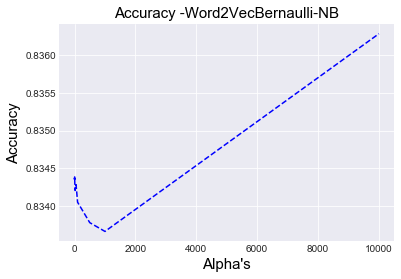

In [38]:
Accplot(g, 'Word2Vec', 'Bernaulli-NB')

### Hyperparameters vs Error Plot

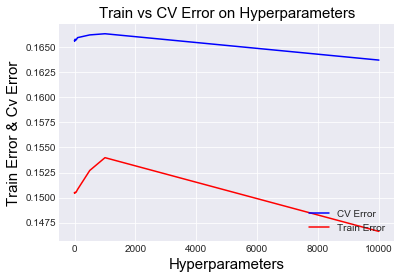

The Train Error is -:  15.1 %

The CV Error is -:  16.6 %



In [39]:
Errorplot(g)Errorplot(g)

### Predicting on Best Hyperparameter

In [40]:
clf, pred = predict('B', 10000, sent_vectors, y_train, sent_vectors1)

### Measuring Performance

In [41]:
Measure(y_test,pred)

Accuracy on Test Data -:  82.066 % 

F1 Score -:   0.895 

Precision Score -:  0.867 

Recall Score -:  0.925 

Test Error -:  17.934


### Confusion Matrix

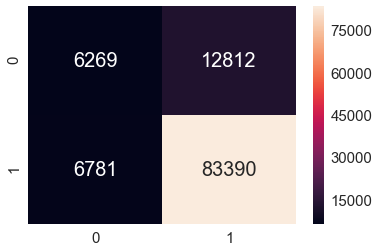

In [42]:
CF(y_test,pred)

## MULTINOMIAL NAIVE BAYES

#### Not possible, as multinomial naive bayes does not work with negative values. 

# tf-IDF Word2Vec

###  SPLITTING INTO TRAIN AND TEST

In [51]:
x_train, x_test, y_train, y_test = Split(Data['CleanedText'].values,Data['Score'].values)

###  CONVERTING REVIEWS INTO VECTORS USING tf-IDF

In [52]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1)) 
x_train = tf_idf_vect.fit_transform(x_train)
x_test = tf_idf_vect.transform(x_test)

###  CONVERTING REVIEWS INTO VECTORS USING tf-IDF WORD2VEC

In [53]:
tfidf_feat = tf_idf_vect.get_feature_names()

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in Train: # for each review/sentence
    #print(row)
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = x_train[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

C:\Users\15-AU008TX\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [54]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in Test: # for each review/sentence
    #print(row)
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = x_test[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

C:\Users\15-AU008TX\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


### Checking NaN Values

In [55]:
train_data = np.array(tfidf_sent_vectors_train)
test_data = np.array(tfidf_sent_vectors_test)
print(np.isnan(train_data).any())
print(np.isnan(test_data).any())

True
True


### SAVING

In [75]:
# Saving for future assignments.
save(train_data,"tfidf-W2v-train")
save(test_data,"tf-idf-w2v-test")

In [76]:
# Creating new dataframes and putting array values in it.
train_d = pd.DataFrame(train_data)
test_d = pd.DataFrame(test_data)

In [79]:
'''
replacing Nan values with constant in whole dataframes.
'''
train_d = train_d.fillna(0)
test_d = test_d.fillna(0)

In [80]:
print(train_d.shape)
print(test_d.shape)

(254919, 100)
(109252, 100)


## BERNAULLI NAIVE BAYES

![Bernaulli NB](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRlw46MRGl3Ox4cZTzXJ0PksGvVc4xWxjRsPQy949u8llCO399y)

### Calling NB Function with training dataset

In [85]:
t, g = NB(train_d, y_train, 'B')

In [86]:
print("Time taken to complete -: ",t,"sec\n")
print("Best Hyperparameter -: ",g.best_params_,"\n")
print("Accuracy -: ",round(g.best_score_*100,3),"%")

Time taken to complete -:  138.74359464645386 sec

Best Hyperparameter -:  {'alpha': 10} 

Accuracy -:  83.369 %


### Alpha vs Accuracy Plot

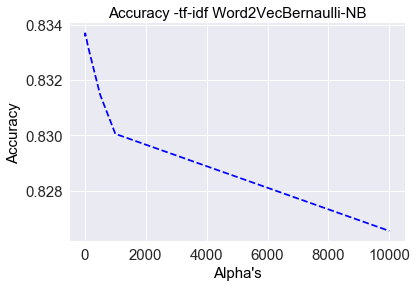

In [87]:
Accplot(g, 'tf-idf Word2Vec', 'Bernaulli-NB')

### Hyperparameters vs Error Plot

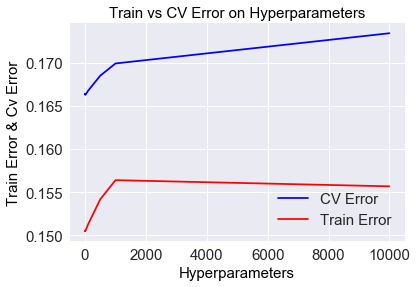

The Train Error is -:  15.1 %

The CV Error is -:  16.7 %



In [88]:
Errorplot(g)

### Predicting on Best Hyperparameter

In [89]:
clf, pred = predict('B', 10, train_d, y_train, test_d)

### Measuring Performance

In [90]:
Measure(y_test,pred)

Accuracy on Test Data -:  82.247 % 

F1 Score -:   0.891 

Precision Score -:  0.903 

Recall Score -:  0.88 

Test Error -:  17.753


### Confusion Matrix

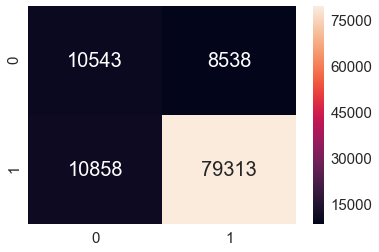

In [91]:
CF(y_test,pred)

#       -------------------------------------------------------------------------------------------------------

![](https://i2.wp.com/www.gobloggingtips.com/wp-content/uploads/2014/11/Strong-blog-post-conclusions-e1454487099243.jpg?fit=639%2C447&ssl=1)

In [92]:
x = PrettyTable()

x.field_names = ["NLP Technique", "Algorithm", "Hyperparameter", "Accuracy(%)", "F1 Score", "Recall Score", "Precision Score"]

x.add_row(["BOW", "Bernaulli NB", 0.001, 88.871, 0.936, 0.988, 0.889])
x.add_row(["BOW", "Multinomial NB", 0.001, 88.916, 0.937, 0.993, 0.886])
x.add_row(["tf-IDF", "Bernaulli NB", 0.001, 88.871, 0.936, 0.988, 0.889])
x.add_row(["tf-IDF", "Multinomial NB", 0.02, 89.811, 0.941, 0.990, 0.897])
x.add_row(["Avg Word2Vec", "Bernaulli NB", 10000, 82.066, 0.895, 0.925, 0.867])
x.add_row(["Avg Word2Vec", "Multinomial NB", "-", "-", "-", "-", "-"])
x.add_row(["tf-IDF Word2Vec", "Bernaulli NB", 10, 82.247, 0.891, 0.880, 0.903])
x.add_row(["tf-IDF Word2Vec", "Multinomial NB", "-", "-", "-", "-", "-"])

print(x)

+-----------------+----------------+----------------+-------------+----------+--------------+-----------------+
|  NLP Technique  |   Algorithm    | Hyperparameter | Accuracy(%) | F1 Score | Recall Score | Precision Score |
+-----------------+----------------+----------------+-------------+----------+--------------+-----------------+
|       BOW       |  Bernaulli NB  |     0.001      |    88.871   |  0.936   |    0.988     |      0.889      |
|       BOW       | Multinomial NB |     0.001      |    88.916   |  0.937   |    0.993     |      0.886      |
|      tf-IDF     |  Bernaulli NB  |     0.001      |    88.871   |  0.936   |    0.988     |      0.889      |
|      tf-IDF     | Multinomial NB |      0.02      |    89.811   |  0.941   |     0.99     |      0.897      |
|   Avg Word2Vec  |  Bernaulli NB  |     10000      |    82.066   |  0.895   |    0.925     |      0.867      |
|   Avg Word2Vec  | Multinomial NB |       -        |      -      |    -     |      -       |        -  

![](https://clip2art.com/images/professional-clipart-conclusion-18.jpg)

### 1. The comparison shows that tf-IDF is a good technique on Naive Bayes for this dataset with an accuracy of 89.811 %.
### 2. Therefore the best hyperparameter is 0.02 with an F1 Score of 0.941, recall Score of 0.99 and a precision of 0.897
### 3. Multinomial Naive Bayes is giving better results as compared to Bernaulli Naive Bayes. 
### 4. Multinomial Naive Bayes is not good for the data set having negative values as it does not work with negative values.
### 5. The basic assumption of naive bayes is that features are independent and i think this is the reason that it does not perform well with Word2Vec or tf-IDF Word2Vec.
### 6. Naive Bayes is better than Knn as it is very fast as compared to Knn so it will be useful if we want the result in less time.
 